# Em construção - Pode conter erros


Notebook elaborado para estudar os princípios do método gravimétrico.
Criado para a disciplina Geofísica I da Universidade Federal de Uberlândia.
O uso e a reprodução são livres para fins educacionais, pede-se apenas a citação da fonte.

[![License: GPL v3](https://img.shields.io/badge/License-GPLv3-blue.svg)](https://www.gnu.org/licenses/gpl-3.0)


Prof. Dr. Emerson Rodrigo Almeida<br>
Universidade Federal de Uberlândia<br>
Instituto de Geografia - Curso de Geologia<br>
emerson.almeida@ufu.br<br>

<p>&nbsp;</p>
Última modificação: 25/02/2021

# Instruções iniciais

Neste notebook você irá visualizar a anomalia Bouguer em regiões específicas do mundo. Para isto leia atentamente as instruções apresentadas antes de cada célula e execute-as uma a uma, para acompanhar o processo corretamente.

Não se preocupe em compreender o código em si, não é obrigatório que você conheça a programação para obter e interpretar os resultados da demonstração. Mesmo assim, sinta-se livre caso queira perguntar qualquer coisa para aprender mais sobre o código e sua elaboração.

<p>&nbsp;</p>

### Passo 01 - Preparação

Primeiramente vamos preparar o ambiente para a execução da demonstração. Será preciso instalar o [SimPEG](https://simpeg.xyz/), que é um pacote open source para modelagem de dados geofísicos. Se você estiver executando este notebook pelo Binder ou pelo Colab execute a célula abaixo para instalar o SimPEG remotamente. Se preferir, pode instalar o pacote diretamente no seu computador ([instruções aqui](https://docs.simpeg.xyz/content/basic/installing.html)) e excluir a célula, porém é recomendável que faça isso **SOMENTE** se você já tiver familiaridade com este tipo de procedimento para evitar qualquer problema.

Você pode executar o código na célula clicando sobre ela e em seguida clicando no botão **RUN** na barra do Jupyter Notebook ou pressionando as teclas **SHIFT+ENTER** no seu teclado. Se você preferir executar este notebook localmente, no seu computador, então exclua a célula abaixo para não afetar a sua instalação.

In [1]:
# importa e instala o SimPEG - Célula exclusiva para execução em ambiente remoto

# baseado no exemplo em https://docs.simpeg.xyz/content/tutorials/03-gravity/plot_1a_gravity_anomaly.html#sphx-glr-content-tutorials-03-gravity-plot-1a-gravity-anomaly-py

# !git clone https://github.com/simpeg/simpeg
# %cd simpeg
# !pip install -r requirements.txt
# !python setup.py install

Agora importe os módulos e defina as funções que precisaremos no decorrer da demonstração. A célula abaixo contém as funções utilizadas nos cálculos e as funções utilizadas para gerar as figuras. Execute-a uma vez antes de executar qualquer outra parte do código e **não altere nada no código apresentado na célula** para não criar problemas na execução do código.

<p>&nbsp;</p>

**Importante!** Nem todas as células irão retornar algum tipo de mensagem ou figura após a execução. Isto é normal e não significa que a execução tenha falhado. Perceba o símbolo **In [   ]:** próximo ao canto superior esquerdo de cada célula. Ao iniciar a execução de uma delas você verá um asterisco ($*$) aparecer dentro dos colchetes. Você saberá que a execução ocorreu sem problemas quando o $*$ dentro dos colchetes for substituído por um número e nenhuma mensagem de erro aparecer abaixo da célula executada.

In [2]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

from discretize import TensorMesh
from discretize.utils import mkvc

from SimPEG.utils import plot2Ddata, model_builder, surface2ind_topo
from SimPEG import maps
from SimPEG.potential_fields import gravity

class modelo():
    
    """
    Define as dimensões, topografia e malha de tensores do modelo
    """
    
    def __init__(self, par_x, par_y, par_z, topografia=None):
        
        """
        par_x:    parâmetros de comprimento e discretização do eixo x do modelo
        par_y:    parâmetros de comprimento e discretização do eixo y do modelo
        par_z:    parâmetros de comprimento e discretização do eixo z do modelo
        rho_bg:   densidade do background homogêneo
        """
        
        # cria os eixos x, y e z do modelo
        self.xx_m = np.linspace(-1 * par_x[0]/2, par_x[0]/2, 1 + int(par_x[0]/par_x[1]))
        self.yy_m = np.linspace(-1 * par_y[0]/2, par_y[0]/2, 1 + int(par_y[0]/par_y[1]))
        self.zz_m = np.linspace(0.0, par_z[0], 1 + int(par_z[0]/par_z[1]))
        
        
        # densidade das rochas do background - é zero porque o modelo vai considerar só
        # o contraste, não o valor absoluto
        self.densidade_background = 0.0
        
        
        # Define a topografia do modelo
        [x_topo, y_topo] = np.meshgrid(self.xx_m, self.yy_m)
        if topografia=='default':
            z_topo = -15.0 * np.exp(-(x_topo ** 2 + y_topo ** 2) / 80 ** 2)

        elif not topografia:
            z_topo = np.zeros((len(self.yy_m), len(self.xx_m)))

        x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
        self.xyz_topo = np.c_[x_topo, y_topo, z_topo]


        # Define a malha de tensores em células de tamanho regular
        dx = self.xx_m[1]-self.xx_m[0]
        dy = self.yy_m[1]-self.yy_m[0]
        dz = self.zz_m[1]-self.zz_m[0]

        nx = int((np.max(self.xx_m)-np.min(self.xx_m))/dx)
        ny = int((np.max(self.yy_m)-np.min(self.yy_m))/dy)
        nz = int((np.max(self.zz_m)-np.min(self.zz_m))/dz)
        
        hx = [(dx, nx)]
        hy = [(dy, ny)]
        hz = [(dz, nz)]

        self.mesh = TensorMesh([hx, hy, hz], 'CCN')
        
        # Find the indices for the active mesh cells (e.g. cells below surface)
        self.ind_active = surface2ind_topo(self.mesh, self.xyz_topo)

        # Define mapping from model to active cells. The model consists of a value for
        # each cell below the Earth's surface.
        nC = int(self.ind_active.sum())
        self.model_map = maps.IdentityMap(nP=nC)

        # Define o modelo com a densidade do background. Models in SimPEG are vector arrays.
        self.model = self.densidade_background * np.ones(nC)
        
        
    def insere_esfera(self, drho, z, raio):
        ind_sphere = model_builder.getIndicesSphere([0.0, 0.0, (z-raio)], raio, self.mesh.gridCC)
        ind_sphere = ind_sphere[self.ind_active]
        self.model[ind_sphere] = drho
        
        
    def insere_bloco(self, rho, vertices):
        """
        vertices: lista de tuplas -> [(xi, xf),(yi, yf),(zi, zf)]
        """
        
        ind_block = ((self.mesh.gridCC[self.ind_active, 0] > vertices[0][0])
                    & (self.mesh.gridCC[self.ind_active, 0] < vertices[0][1])
                    & (self.mesh.gridCC[self.ind_active, 1] > vertices[1][0])
                    & (self.mesh.gridCC[self.ind_active, 1] < vertices[1][1])
                    & (self.mesh.gridCC[self.ind_active, 2] > vertices[2][0])
                    & (self.mesh.gridCC[self.ind_active, 2] < vertices[2][1]))
        self.model[ind_block] = rho
        
    
    def plota_corte(self, direcao, posicao):

        if direcao.upper()=='X':
            indice_slice = np.abs(posicao - self.xx_m).argmin()
        
        if direcao.upper()=='Y':
            indice_slice = np.abs(posicao-self.yy_m).argmin()
            
        if direcao.upper()=='Z':
            indice_slice = np.abs((np.max(self.zz_m)-np.abs(posicao))-self.zz_m).argmin()
        
        fig = plt.figure(figsize=(15, 5))
        plotting_map = maps.InjectActiveCells(self.mesh, self.ind_active, np.nan)

        ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
        
        self.mesh.plot_slice(
            plotting_map * self.model,
            normal=direcao,
            ax=ax1,
            ind=int(self.mesh.nCy / 2),
            grid=True,
            clim=(np.min(self.model), np.max(self.model)),
            pcolorOpts={"cmap": "viridis"},
        )
        ax1.set_title('Corte em ' + direcao.upper() + ' = ' + str(posicao) + ' m')
        
        if direcao=='Y':
            ax1.set_xlabel('Distância em X (m)', fontsize=14)
            ax1.set_ylabel('Profundidade (m)', fontsize=14)
            
        elif direcao=='X':
            ax1.set_xlabel('Distância em Y (m)', fontsize=14)
            ax1.set_ylabel('Profundidade (m)', fontsize=14)
            
        elif direcao=='Z':
            ax1.set_xlabel('Distância em X (m)', fontsize=14)
            ax1.set_ylabel('Distância em Y (m)', fontsize=14)

        ax2 = fig.add_axes([0.85, 0.12, 0.025, 0.78])
        norm = mpl.colors.Normalize(vmin=np.min(self.model), vmax=np.max(self.model))
        cbar = mpl.colorbar.ColorbarBase(
            ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
        )
        cbar.set_label("$ \Delta rho (g/cm^3)$", rotation=90, labelpad=15, size=12)

        plt.show()

        
class aquisicao():
    
    def __init__(self, xx_s, yy_s, h_s, mod, componente='gz'):
    
        """
        Configura os pontos do levantamento no modelo
        
        The user only needs an (N, 3) array to define the xyz locations of the observation locations, 
        and a list of field components which are to be measured.
        
        xx_s:    coordenadas x dos pontos de levantamento
        yy_s:    coordenadas y dos pontos de levantamento
        h_s:     elevação do levantamento
        mod:     objeto da classe modelo
        """
        
        self.xx_s = xx_s
        self.yy_s = yy_s
        self.h_s = h_s
        self.componente = componente
        
        x, y = np.meshgrid(xx_s, yy_s)

        x = mkvc(x.T)
        y = mkvc(y.T)

        # cria a função de interpolação para o espaço do modelo
        fun_interp = LinearNDInterpolator(np.c_[mod.xyz_topo[:, 0], mod.xyz_topo[:, 1]], mod.xyz_topo[:, 2])

        # interpola as coordenadas das estações e coloca h_s metros acima da superfície
        z = fun_interp(np.c_[x, y]) + h_s
        
        self.receiver_locations = np.c_[x, y, z]

        # Use the observation locations and components to define the receivers. To
        # simulate data, the receivers must be defined as a list.
        receiver_list = gravity.receivers.Point(self.receiver_locations, components=componente)
        self.receiver_list = [receiver_list]

        # Defining the source field.
        self.source_field = gravity.sources.SourceField(receiver_list=self.receiver_list)

        # Defining the survey
        self.survey = gravity.survey.Survey(self.source_field)    # é um objeto
        
        
    def fwd(self, mod):
        
        # Define the forward simulation. By setting the 'store_sensitivities' keyword
        # argument to "forward_only", we simulate the data without storing the sensitivities
        simulation = gravity.simulation.Simulation3DIntegral(
                        survey = self.survey,
                        mesh = mod.mesh,
                        rhoMap = mod.model_map,
                        actInd = mod.ind_active,
                        store_sensitivities = "forward_only",
        )

        # Compute predicted data for some model
        self.dpred = simulation.dpred(mod.model) * (-1)
        
        
    def plota_mapa(self):
        
        nx = len(self.xx_s)
        ny = len(self.yy_s)
        
        matriz_dados = np.reshape(self.dpred, [ny, nx])
        
        fig, ax1 = plt.subplots(figsize=(8,8))
        im = ax1.imshow(matriz_dados, extent=[self.xx_s[0], self.xx_s[-1], self.yy_s[0], self.yy_s[-1]], \
                        cmap='jet_r', vmin=np.min(matriz_dados), vmax=np.max(matriz_dados), interpolation='bicubic')

        plt.colorbar(im, ax=ax1, extend='both', label='mGal', shrink=0.75)
        ax1.set_xlabel('Distância em X (m)', fontsize=14)
        ax1.set_ylabel('Distância em Y (m)', fontsize=14)

        if self.componente=='gx':
            comp = 'X'
        elif self.componente=='gy':
            comp = 'Y'
        elif self.componente=='gz':
            comp = 'Z'
        
        ax1.set_title('Mapa de anomalia (componente ' + minha_aquisicao.componente + ')', fontsize=14)

        plt.show()
        
        
    def plota_perfis(self, coordenadas):
        """
        plota perfis ortogonais que se cruzam nas coordenadas fornecidas
        
        coordenadas: array 1D de duas posições
        """
        
        nx = len(self.xx_s)
        ny = len(self.yy_s)
        
        matriz_dados = np.reshape(self.dpred, [ny, nx])
        
        ind_x = np.abs(self.xx_s-coordenadas[0]).argmin()    # índice da coordenada x no eixo x
        ind_y = np.abs(self.yy_s-coordenadas[1]).argmin()    # índice da coordenada y no eixo y
        
        fig, [ax1, ax2] = plt.subplots(nrows=2, figsize=(14,7))
        ax1.plot(y_rx, matriz_dados[:, ind_x])
        ax1.set_title('Perfil cruzando a anomalia em X='+ str(coordenadas[0]) +' m', fontsize=14)
        ax1.set_xlabel('Distância em Y (m)', fontsize=14)
        ax1.set_ylabel('Anomalia (mGal)', fontsize=14)

        ax2.plot(x_rx, matriz_dados[ind_y,:])
        ax1.set_title('Perfil cruzando a anomalia em Y='+ str(coordenadas[1]) +' m', fontsize=14)
        ax2.set_xlabel('Distância em X (m)', fontsize=14)
        ax2.set_ylabel('Anomalia (mGal)', fontsize=14)

        plt.tight_layout()
        

### Passo 02 - Configuração do modelo

Aqui você irá definir primeiramente as dimensões do espaço do modelo, informando o comprimento que você deseja que seu modelo tenha e qual a discretização que deseja para ele. Cada variável na célula abaixo define uma dimensão para um eixo do modelo tridimensional.

Para este exemplo vamos começar com um modelo que tem 400 m de comprimento (direção X), 400 m de largura (direção Y) e 100 de profundidade (direção Z). Configure estes valores executando a célula.

In [3]:
eixo_x = [100.0, 1.0]      # [comprimento, delta]
eixo_y = [100.0, 1.0]      # [comprimento, delta]
eixo_z = [40.0, 1.0]       # [comprimento, delta]

A modelagem neste exemplo considera os contrastes de densidade para as rochas, e não os seus valores absolutos. A densidade da crosta continental varia entre 2.65 e 2.80 g/cm$^3$, então neste exemplo vamos utilizar o valor médio de 2.72 g/cm$^3$ como um valor de referência.

Execute a célula abaixo para gerar o modelo.

In [4]:
meu_modelo = modelo(eixo_x, eixo_y, eixo_z)

Agora você irá inserir um contraste de densidade no modelo para simular um corpo na rocha encaixante. Aqui este contraste será representado por um corpo de geometria simples: um corpo esférico. Para isto é necessário definir o valor de densidade deste corpo, as coordenadas x, y e z do seu ponto central no espaço do modelo e o seu raio.

Execute a célula abaixo para inserir no modelo uma esfera com contraste de densidade igual a 0.3 g/cm$^3$ (trata-se, portanto, de um corpo de densidade 2.75 g/cm$^3$) à profundidade de 15.0 e com 5.0 m de raio.

In [5]:
meu_modelo.insere_esfera(0.3, -15.0, 5)

Execute a célula abaixo para exibir uma vista em corte do modelo e visualizar se o corpo foi posicionado corretamente.

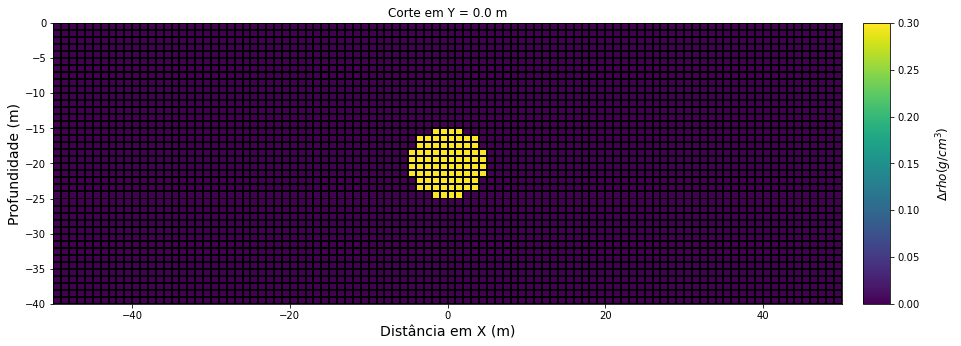

In [6]:
meu_modelo.plota_corte('Y', 0.0)

### Passo 3 - Configuração da aquisição

Agora será preciso definir os parâmetros de aquisição de dados, i.e., os pontos onde serão realizadas as medidas de aceleração de gravidade sobre o modelo. Estes dados serão adquiridos em uma grade de pontos equiespaçados distribuídos na superfície do modelo, portanto será preciso definir os pontos inicial e final para o eixo X e para o eixo Y, assim como o número de pontos ao longo de cada direção.

Execute a célula abaixo para definir um levantamento realizado entre as coordenadas -150.0 e 150 do eixo X e entre as coordenadas -150.0 e 150.0 m do eixo Y, com 30 pontos de aquisição em cada eixo.

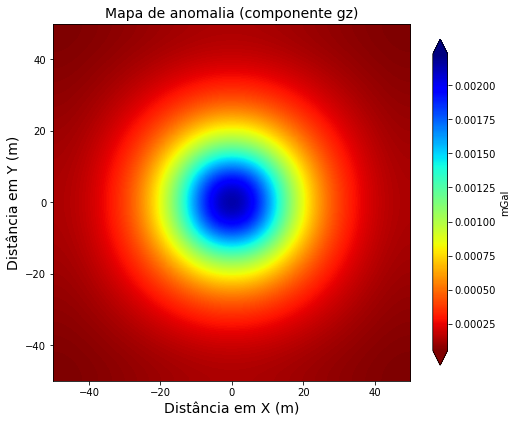

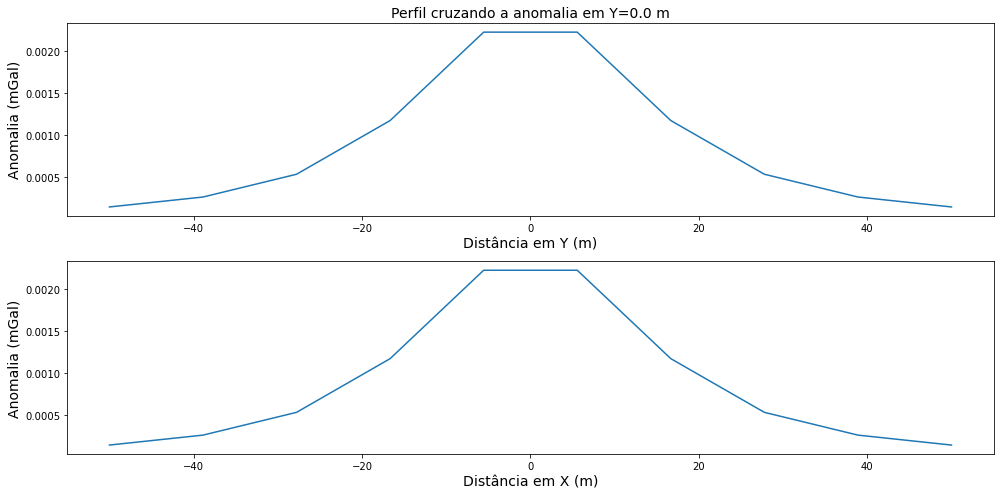

In [7]:
x_rx = np.linspace(-50, 50.0, 10)
y_rx = np.linspace(-50.0, 50.0, 10)
h_rx = 0.0

minha_aquisicao = aquisicao(x_rx, y_rx, h_rx, meu_modelo, componente='gz')

minha_aquisicao.fwd(meu_modelo)

minha_aquisicao.plota_mapa()
minha_aquisicao.plota_perfis([0.0, 0.0])